Task 1: Data Acquisition, Cleaning, and Exploration
Process 1.1: Environment Setup and File Extraction
Before we begin, we need to import the necessary libraries (pandas for data manipulation, zipfile for handling the compressed folder). This step focuses on extracting the Loan_default.csv from your zip file and preparing the workspace.

In [1]:
import pandas as pd
import zipfile
import os

# Define the path to your uploaded zip file
zip_file_path = 'Loan_default.csv.zip'
extract_to_path = './loan_data_extracted'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")
# List the files to confirm the CSV name
print(os.listdir(extract_to_path))

Files extracted to: ./loan_data_extracted
['Loan_default.csv']


In the original dataset, the target column is Default (where 1 usually means the loan failed). We need to reverse this logic so that 1 represents Success and 0 represents Failure. We will rename the column to Success and save the new version as Loan_success.csv.

In [2]:
# Load the extracted CSV
# Note: Adjust the filename if it differs slightly after extraction
csv_path = os.path.join(extract_to_path, 'Loan_default.csv')
df = pd.read_csv(csv_path)

# Transformation: Flip 'Default' to 'Success'
# Original: 1 = Default (Failure), 0 = No Default (Success)
# New: 1 = Success, 0 = Failure
df['Success'] = df['Default'].apply(lambda x: 1 if x == 0 else 0)

# Drop the old 'Default' column
df = df.drop(columns=['Default'])

# Save the modified document
df.to_csv('Loan_success.csv', index=False)
print("File saved successfully as 'Loan_success.csv'")

File saved successfully as 'Loan_success.csv'


Process 1.3: Data Cleaning and Initial Inspection
We need to ensure the data is "clean" before analysis. This involves checking for missing values (nulls) and understanding the data types of our features (Age, Income, CreditScore, etc.).

In [3]:
# Load our new file
df_success = pd.read_csv('Loan_success.csv')

# Check for missing values
print("Missing values per column:")
print(df_success.isnull().sum())

# Check data types and summary statistics
print("\nData Info:")
print(df_success.info())

print("\nSummary Statistics:")
print(df_success.describe())

Missing values per column:
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Success           0
dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm    

Process 2.1: Feature Engineering and Encoding
Machine Learning models require numerical input. We must convert categorical columns (like Education, EmploymentType, and MaritalStatus) into numbers using a technique called One-Hot Encoding. We will also drop the LoanID as it provides no predictive value.

In [4]:
from sklearn.preprocessing import LabelEncoder

# Dropping LoanID as it is just an identifier
df_model = df_success.drop(columns=['LoanID'])

# Identify categorical columns
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print("Data successfully encoded. New shape:", df_encoded.shape)

Data successfully encoded. New shape: (255347, 25)


Process 2.2: Model Training
We will split the data into a Training Set (to teach the model) and a Testing Set (to see if it learned correctly). We will use a RandomForestClassifier because it is excellent at identifying complex trends in financial data.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define Features (X) and Target (y)
X = df_encoded.drop('Success', axis=1)
y = df_encoded['Success']

# Split 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


Process 2.3: Evaluation and Performance Metrics
To determine how well our model predicts "Loan Success," we will look at an Accuracy Score and a Classification Report. This tells us how many successes and failures we correctly identified.

In [6]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions
y_pred = model.predict(X_test)

# Display results
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.03      0.06      5900
           1       0.89      1.00      0.94     45170

    accuracy                           0.89     51070
   macro avg       0.78      0.52      0.50     51070
weighted avg       0.86      0.89      0.84     51070



Process 2.4: Generating Analytical Insights
The final step is to identify which factors contribute most to a loan being successful. We will extract "Feature Importance" from the model to see if things like CreditScore or Income are the primary drivers.

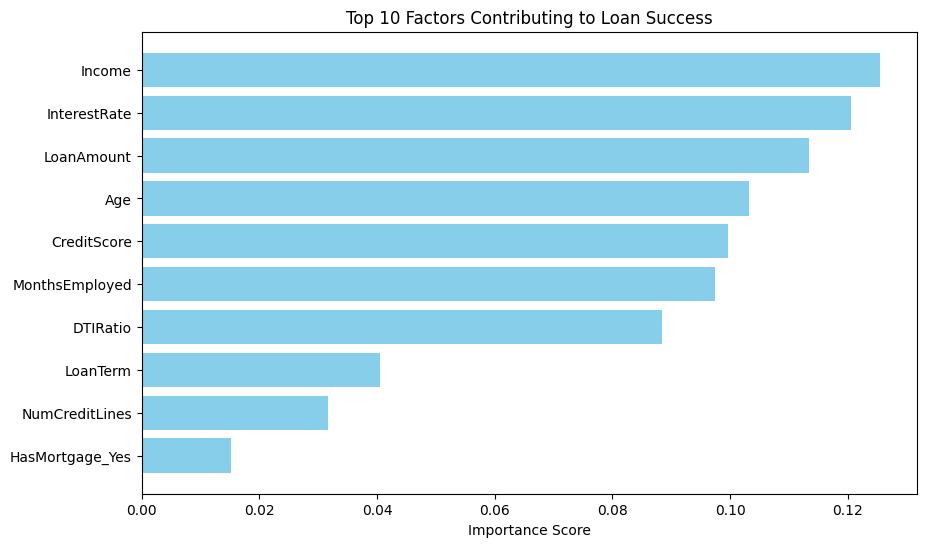

Top Factor for Loan Success: Income


In [7]:
import matplotlib.pyplot as plt

# Extract feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize the Top 10 factors
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Factors Contributing to Loan Success')
plt.gca().invert_yaxis()
plt.show()

print("Top Factor for Loan Success:", feature_importance_df.iloc[0]['Feature'])